# Langtjern TOC interpolation at outlet

## Required python libraries and files, setup variables

In [1]:
import sys
import LangtjernWeather as lw
import numpy as np
import datetime
import pandas as pd
import getpass
import matplotlib
import matplotlib.pyplot as plt
import getpass
import itertools as IT
from itertools import compress
from matplotlib import rc
import shutil
import os
import re
import pickle
import pylab
import statsmodels.api as sm
from patsy import dmatrices

#Setting matplotlib style
matplotlib.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None
rc('text', usetex=True)
rc('xtick', labelsize = 16)
rc('ytick', labelsize = 16)
rc('font', size = 16)
#login function
def login():
    username = input("Username: [JLG] ") #default username JLG
    if not username :
        username = "JLG"
    password = getpass.getpass('Password: ')
    return username, password

#Creating directories to store files. This will overwrite if the directory already exists
def create_dir(dir_name) :
    if not os.path.exists(dir_name) :
        os.makedirs(dir_name)
    else :
        shutil.rmtree(dir_name)
        os.makedirs(dir_name)
#Helper function for plotting
def plot_df(df) :
    num_cols = len(df.columns)
    fig, axes = plt.subplots(nrows = num_cols, ncols = 1, figsize = (20, num_cols * 5))
    for name,ax_h in zip(df.columns, axes) :
        plt.sca(ax_h)
        plt.plot(df.index,df[name])
        #df[name].plot(ax = ax_h)
        ax_h.set_ylabel(name)
    return fig

def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

#Sanity check
print("Using python version:")
print(sys.version)
print("Paths to python libraries:")
print(sys.path)

#Creating directory to save results
result_dir = './results/'
create_dir(result_dir)    

Using python version:
3.6.8 (default, Apr  9 2019, 04:59:38) 
[GCC 8.3.0]
Paths to python libraries:
['/home/jose-luis/Envs/niva_prognos/lib/python36.zip', '/home/jose-luis/Envs/niva_prognos/lib/python3.6', '/home/jose-luis/Envs/niva_prognos/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '', '/home/jose-luis/Envs/niva_prognos/lib/python3.6/site-packages', '/home/jose-luis/Envs/niva_prognos/lib/python3.6/site-packages/IPython/extensions', '/home/jose-luis/.ipython']


## Asking for credentials to AquaMonitor.

In [2]:
username,password = login()

#Folder where the downloaded data will be saved
root = "./DownloadedData/"
create_dir(root)

Username: [JLG]  
Password:  ··········


## Defining period to download

In [3]:
fromDate = "1970/01/01"
toDate = "2018/12/31"

## Loading data at inlet

In [4]:
chemistry = lw.getLangtjernData(username,password,root,fromDate,toDate, 37933, 'Water')
#del password
chemistry.drop(['Depth1', 'Depth2','ProjectId', 'ProjectName', 'StationId', 'StationCode',
                'StationName','SampleDate_dato', 'SampleDate_tid'], inplace=True, axis=1) 
# chemistry.replace('< 1','Null')
# chemistry.replace('< 0,06','Null')
chemistry = chemistry[chemistry.applymap(isnumber)]

chemistry = chemistry.rename(columns=lambda x: re.sub('[_/]',' ',x))
chemistry = chemistry.astype('float64',errors='ignore')
print("The data that were read are: {}".format(chemistry.columns))

The data that were read are: Index(['Al µg l', 'Al IL µg l', 'Al L µg l', 'Al R µg l', 'Alk 4.5 mmol l',
       'ANC µEkv L', 'As µg l', 'Au µg l', 'Ba µg l', 'Ca mg L', 'Cd µg l',
       'Ce µg l', 'Cl mg L', 'Co µg l', 'Cr µg l', 'Cu mg l', 'DOC mg L C',
       'Er µg l', 'Eu µg l', 'Farge mg Pt l', 'Fe µg l', 'Hg ng l', 'Ho µg l',
       'K mg L', 'KOND20 µS cm', 'Konduktivitet mS m', 'Mg mg L', 'Mn µg l',
       'Mo µg l', 'Na mg L', 'NH4-N µg l', 'Ni µg L', 'NO3-N µg l', 'Pb mg l',
       'PCB101 ng l', 'PCB28 ng l', 'Pd µg l', 'pH', 'PO4-P µg l', 'Pt µg l',
       'S µg l', 'SiO2 mg l', 'Sm µg l', 'SO4 mg L', 'SO4 Old mg l', 'Sr µg l',
       'TOC mg l', 'TOTN µg l', 'TOTP µg l', 'UV absorbans Abs cm',
       'UV-Abs. 254nm Abs cm', 'UV-Abs. 365nm Abs cm', 'UV-Abs. 410nm Abs cm',
       'Y µg l', 'Zn mg l'],
      dtype='object')


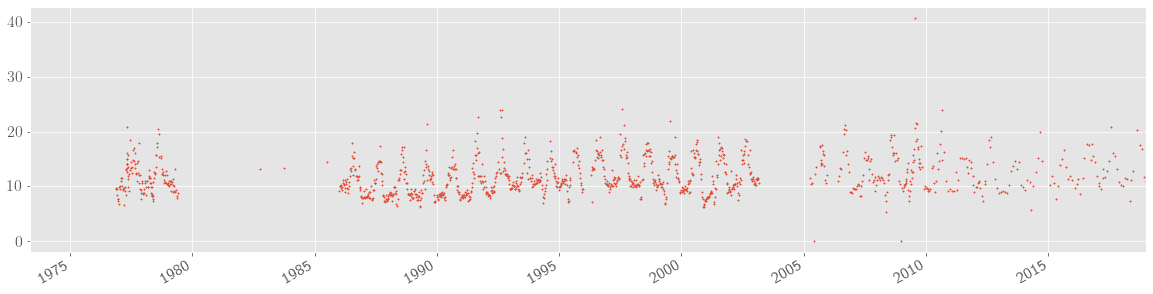

In [5]:
chemistry['TOC mg l'].plot(subplots=True,figsize=(20,5),linestyle='None',marker='.',markersize=1)
TOC=chemistry['TOC mg l']
TOC = TOC[~TOC.index.duplicated(keep='first')]

## Getting CDOM

In [6]:
inlet = lw.getLangtjernData(username,password,root,fromDate,toDate, 63098, 'Water')
inlet.drop(['Depth1', 'Depth2','ProjectId', 'ProjectName', 'StationId', 'StationCode',
             'StationName','SampleDate_dato', 'SampleDate_tid'], inplace=True, axis=1) 
inlet = inlet.rename(columns=lambda x: re.sub('[_/]',' ',x))
inlet = inlet.rename(columns=lambda x: re.sub('µ','u',x))
print("The data that were read are: {}".format(inlet.columns))

The data that were read are: Index(['CDOM ug L', 'Temperatur C', 'Vannstand m'], dtype='object')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe172bb99b0>,
      dtype=object)

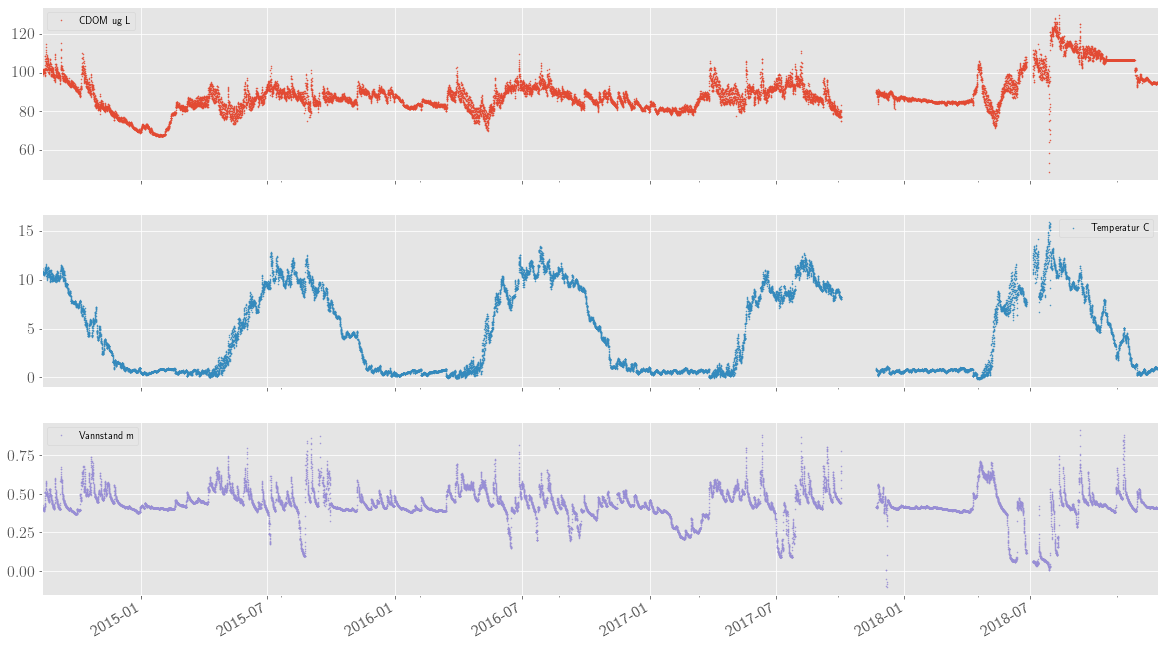

In [7]:
inlet.plot(subplots=True,figsize=(20,12),linestyle='None',marker='.',markersize=1)

## Getting radiation

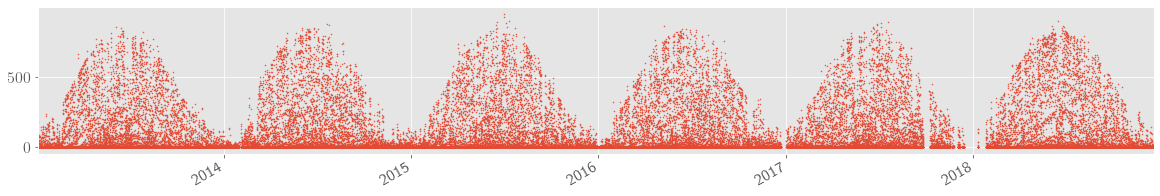

In [8]:
radiation = lw.getLangtjernData(username,password,root,fromDate,toDate, 62040, 'Air')
radiation = radiation['Globalstråling_W/m2']
radiation.columns = ['radiation']
radiation = radiation.astype('float64')
radiation.plot(figsize=(20,3),marker='.',markersize=1,linestyle='')

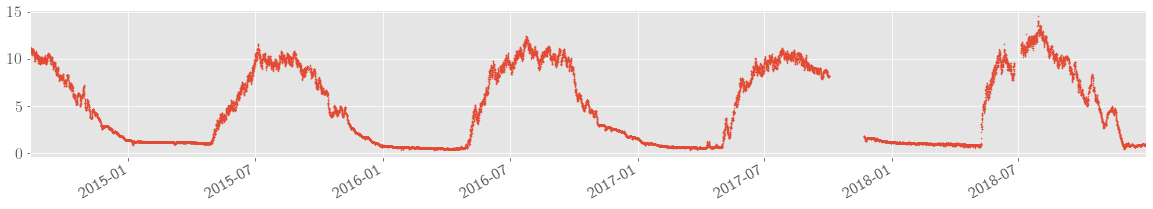

In [9]:
soilTemp = lw.getLangtjernData(username,password,root,fromDate,toDate, 63099, 'Water')
soilTemp = soilTemp.loc[[i == 0.15 for i in soilTemp['Depth1']],:]
soilTemp = soilTemp['Temperatur_C']
soilTemp = soilTemp.astype('float64')
soilTemp.plot(figsize=(20,3),marker='.',markersize=1,linestyle='')

## Finding relation between CDOM, TOC, temperature at the inlet 

### Interpolation using daily data

Index(['Temperatur_C'], dtype='object')

Index(['soilTemperature'], dtype='object')

Index(['soilTemperature'], dtype='object')

Index(['CDOM', 'TOC', 'Temperature', 'gh', 'radiation', 'soilTemperature'], dtype='object')

,CDOM,TOC,Temperature,gh,radiation,soilTemperature
2014-08-24 16:10:00,105.300000,19.9,10.530833,0.491233,225.339782,10.037500
2014-09-28 14:56:00,92.566667,14.7,7.819333,0.377467,167.059824,8.341333
2015-01-25 14:00:00,67.950000,10.3,0.657000,0.406500,48.263310,1.222000
2015-02-22 09:45:00,82.750000,11.8,0.383750,0.441700,232.647650,1.177125
2015-03-29 12:27:00,85.670000,10.6,0.526350,0.447370,441.491020,1.142325
2015-04-27 14:30:00,84.450000,7.7,1.791000,0.537250,426.853150,1.012250
2015-05-25 15:49:00,84.081667,10.0,5.488175,0.456682,216.204600,4.854808
2015-06-28 13:08:00,89.516667,13.9,9.605667,0.420910,617.704827,8.799333
2015-07-26 13:26:00,87.086667,15.0,9.385667,0.434047,97.274470,9.157167
2015-08-30 14:00:00,83.100000,16.7,10.510000,0.479000,386.159300,9.620000


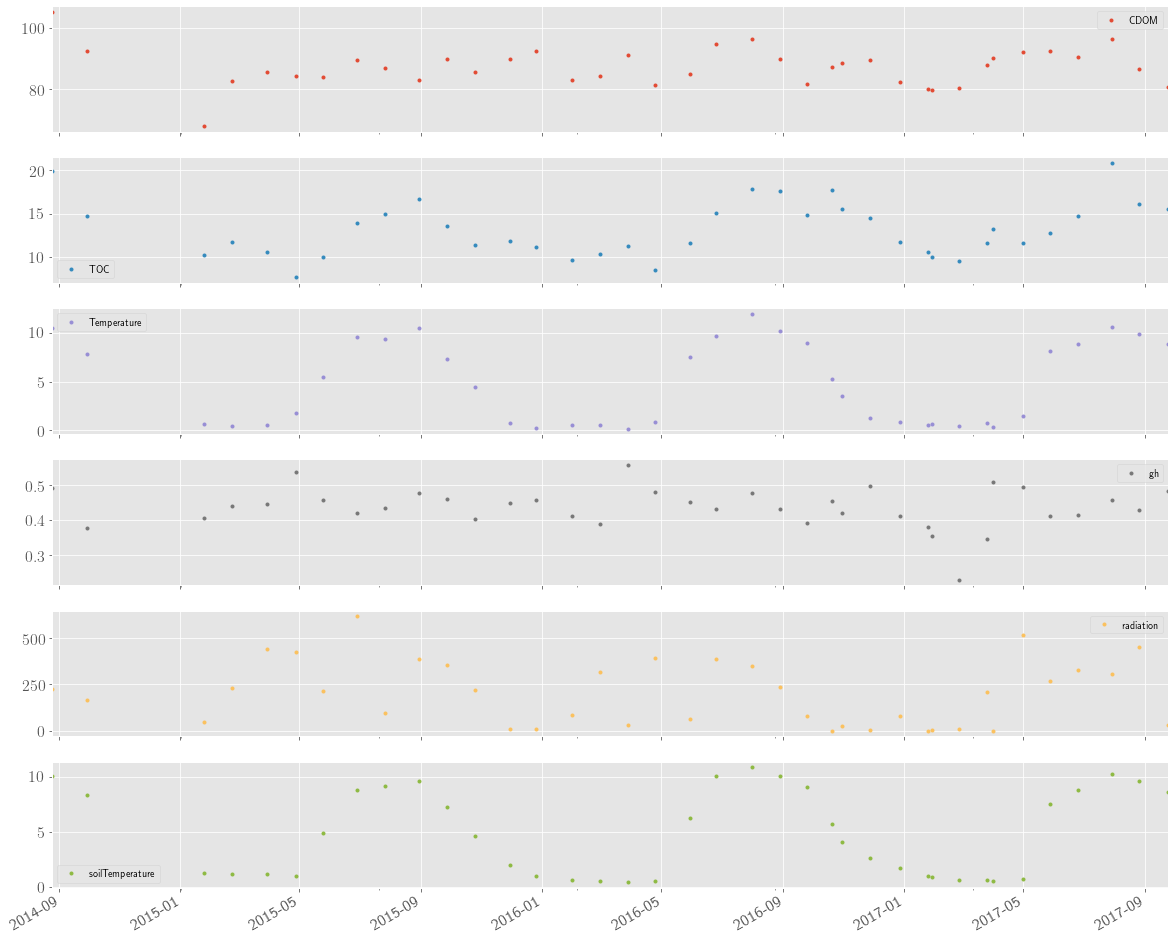

In [10]:
C = TOC.copy()
C = C.dropna().to_frame()
C = C[~C.index.duplicated(keep='first')]
C.rename(columns={'TOC mg l':'TOC'},inplace=True)

out = inlet.copy()
# display(out)
# out.drop(['Vannstand m'],inplace=True, axis=1)
out.rename(columns={'CDOM ug L' : 'CDOM','Temperatur C':'Temperature', 'Vannstand m': 'gh'},inplace=True)
out['Temperature'] = out['Temperature'].apply(lambda x : 0.0 if x < 0.0 else x)
out.interpolate(inplace=True,method='index')

rad=radiation.copy()
rad=rad.to_frame()
rad.rename(columns={'Globalstråling_W/m2':'radiation'},inplace=True)
rad.interpolate(inplace=True,method='index')

soilT = soilTemp.copy()
soilT = soilT.to_frame()
display(soilT.columns)
soilT.rename(columns={'Temperatur_C': 'soilTemperature'},inplace=True)
display(soilT.columns)
soilT.interpolate(inplace=True,method='index')
display(soilT.columns)

data = pd.concat([rad,out,soilT],axis=1,join='outer')
data.interpolate(inplace=True,method='index')
# data.interpolate(inplace=True,method='index')
# data.interpolate(inplace=True)
#data = data[np.isnan(data['TOC'])==False]
# lake[lake['Depth1']==1.0]

start = pd.to_datetime('2014-08-01')
finish = pd.to_datetime('2017-09-30')

# start = pd.to_datetime('2012-04-30')
# finish = pd.to_datetime('2018-12-31')

data = data.loc[start:finish,:]
C = C.loc[start:finish,:]

#data.interpolate(inplace=True,method='index')
data = pd.concat([data,C],axis=0,sort=True)
data.interpolate(inplace=True,method='index')
data = data.dropna()

data.plot(subplots=True,figsize=(20,18),marker='o',markersize=3,linestyle='')
display(data.columns)
display(data)


## Regression

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    TOC   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     25.33
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           1.14e-10
Time:                        16:18:58   Log-Likelihood:                -62.966
No. Observations:                  38   AIC:                             139.9
Df Residuals:                      31   BIC:                             151.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.2208      3.675     -0.060      0.952      -7.717       7.275
CDOM                               0.1120      0.045      2.498      0.018       0.021       0.204
Temperature                       -1.4173      0.512     -2.767      0.009      -2.462      -0.372
soilTemperature                    1.4628      0.508      2.878      0.007       0.426       2.499
gh                                 3.7573      4.366      0.861      0.396      -5.146      12.661
radiation                         -0.0028      0.002     -1.759      0.088      -0.006       0.000
gh:soilTemperature:Temperature     0.1360      0.051      2.672      0.012       0.032       0.240
==============================================================================
Omnibus:                        7.431   Durbin-Watson:                   1.386
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                6.055
Skew:                           0.874   Prob(JB):                       0.0484
Kurtosis:                       3.878   Cond. No.                     5.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

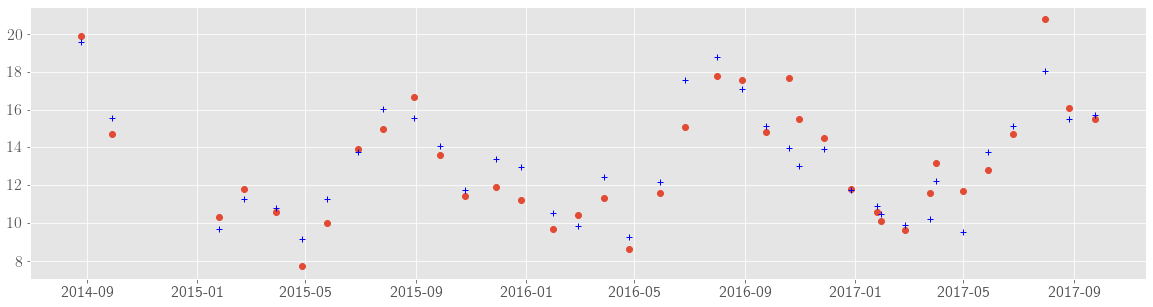

In [11]:
#Performing regression
y, X = dmatrices('TOC ~ CDOM + Temperature + soilTemperature + gh + radiation + gh:soilTemperature:Temperature', data=data, return_type='dataframe')

# Note the difference in argument order
modelDaily = sm.OLS(y, X).fit()
modelDaily.summary()
#fig, ax = plt.subplots()
#fig = sm.graphics.plot_fit(model, 0, ax=ax)
ypred = modelDaily.predict(X)
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(X.index, y['TOC'], 'o', label="TOC")
ax.plot(X.index, ypred, 'b+', label="prediction")
# ax.plot(y['TOC'],ypred,'k.')
modelDaily.summary()

In [12]:
## Regression with daily values

Index(['soilTemperature'], dtype='object')

,CDOM,TOC,Temperature,gh,radiation,soilTemperature
2014-08-24 16:10:00,102.028877,19.9,10.458617,0.488663,3352.441997,9.995307
2014-09-28 14:56:00,92.270185,14.7,7.700111,0.373751,1732.401922,8.126333
2015-01-25 14:00:00,67.554097,10.3,0.699924,0.406224,377.919263,1.213833
2015-02-22 09:45:00,83.322917,11.8,0.399703,0.439991,1327.775018,1.175427
2015-03-29 12:27:00,84.388802,10.6,0.606648,0.450064,2977.987442,1.138499
2015-04-27 14:30:00,80.934219,7.7,1.105444,0.529514,4255.890096,1.046443
2015-05-25 15:49:00,81.055803,10.0,5.347622,0.453104,3325.140970,4.805827
2015-06-28 13:08:00,89.138889,13.9,9.699375,0.416726,6790.010483,9.010095
2015-07-26 13:26:00,88.235324,15.0,9.417102,0.429079,2853.295805,9.246206
2015-08-30 14:00:00,82.232847,16.7,10.236528,0.469055,4033.561815,9.621319


,CDOM,TOC,Temperature,gh,radiation,soilTemperature
2014-08-24 16:10:00,102.028877,19.9,10.458617,0.488663,3352.441997,9.995307
2014-09-28 14:56:00,92.270185,14.7,7.700111,0.373751,1732.401922,8.126333
2015-01-25 14:00:00,67.554097,10.3,0.699924,0.406224,377.919263,1.213833
2015-02-22 09:45:00,83.322917,11.8,0.399703,0.439991,1327.775018,1.175427
2015-03-29 12:27:00,84.388802,10.6,0.606648,0.450064,2977.987442,1.138499
2015-04-27 14:30:00,80.934219,7.7,1.105444,0.529514,4255.890096,1.046443
2015-05-25 15:49:00,81.055803,10.0,5.347622,0.453104,3325.140970,4.805827
2015-06-28 13:08:00,89.138889,13.9,9.699375,0.416726,6790.010483,9.010095
2015-07-26 13:26:00,88.235324,15.0,9.417102,0.429079,2853.295805,9.246206
2015-08-30 14:00:00,82.232847,16.7,10.236528,0.469055,4033.561815,9.621319


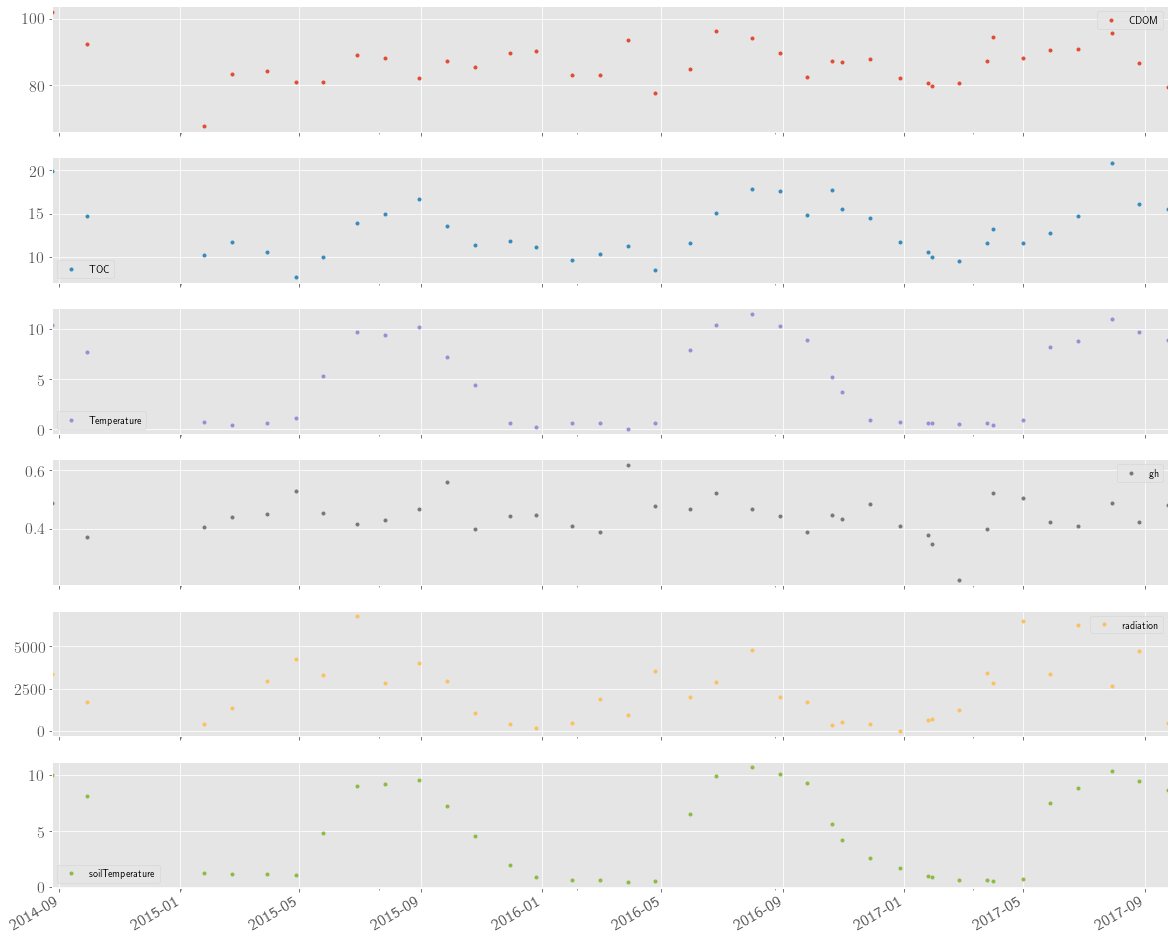

In [13]:
C = TOC.copy()
C = C.dropna().to_frame()
C = C[~C.index.duplicated(keep='first')]
C.rename(columns={'TOC mg l':'TOC'},inplace=True)

out = inlet.copy()
# display(out)
# out.drop(['Vannstand m'],inplace=True, axis=1)
out.rename(columns={'CDOM ug L' : 'CDOM','Temperatur C':'Temperature', 'Vannstand m': 'gh'},inplace=True)
out['Temperature'] = out['Temperature'].apply(lambda x : 0.0 if x < 0.0 else x)
out = out.resample('D').mean()
out.interpolate(inplace=True,method='index')

rad=radiation.copy()
rad=rad.to_frame()
rad.rename(columns={'Globalstråling_W/m2':'radiation'},inplace=True)
rad=rad.resample('D').sum()
rad.interpolate(inplace=True,method='index')

soilT = soilTemp.copy()
soilT = soilT.to_frame()
soilT.rename(columns={'Temperatur_C': 'soilTemperature'},inplace=True)
soilT=soilT.resample('D').mean()
soilT.interpolate(inplace=True,method='index')
display(soilT.columns)

data = pd.concat([rad,out,soilT],axis=1,join='outer')
data.interpolate(inplace=True,method='index')
# data.interpolate(inplace=True,method='index')
# data.interpolate(inplace=True)
#data = data[np.isnan(data['TOC'])==False]
# lake[lake['Depth1']==1.0]

start = pd.to_datetime('2014-08-01')
finish = pd.to_datetime('2017-09-30')

# start = pd.to_datetime('2012-04-30')
# finish = pd.to_datetime('2018-12-31')

data = data.loc[start:finish,:]
C = C.loc[start:finish,:]

#data.interpolate(inplace=True,method='index')
data = pd.concat([data,C],axis=0,sort=True)
data.interpolate(inplace=True,method='index')
data = data.dropna()

data.plot(subplots=True,figsize=(20,18),marker='o',markersize=3,linestyle='')
# display(data.columns)
display(data)
data

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    TOC   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     22.20
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           5.87e-10
Time:                        16:19:01   Log-Likelihood:                -65.028
No. Observations:                  38   AIC:                             144.1
Df Residuals:                      31   BIC:                             155.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.3811      3.870     -0.098      0.922      -8.274       7.512
CDOM                               0.1298      0.046      2.794      0.009       0.035       0.224
Temperature                       -1.4403      0.836     -1.722      0.095      -3.146       0.265
soilTemperature                    1.5996      0.636      2.513      0.017       0.302       2.897
radiation                         -0.0002      0.000     -1.121      0.271      -0.001       0.000
gh:Temperature                     0.1181      1.201      0.098      0.922      -2.331       2.567
gh:soilTemperature:Temperature     0.0974      0.066      1.479      0.149      -0.037       0.232
==============================================================================
Omnibus:                        3.713   Durbin-Watson:                   1.530
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                2.414
Skew:                           0.488   Prob(JB):                        0.299
Kurtosis:                       3.756   Cond. No.                     4.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

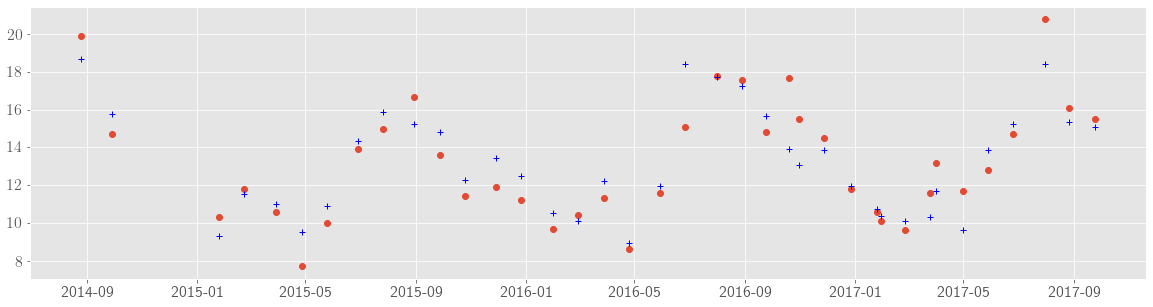

In [14]:
#Performing regression
# y, X = dmatrices('TOC ~ CDOM + Temperature + soilTemperature + radiation + gh:Temperature:soilTemperature', data=data, return_type='dataframe')
y, X = dmatrices('TOC ~ CDOM + Temperature + soilTemperature + radiation + gh:Temperature + gh:soilTemperature:Temperature', data=data, return_type='dataframe')

# Note the difference in argument order
model = sm.OLS(y, X).fit()
model.summary()
#fig, ax = plt.subplots()
#fig = sm.graphics.plot_fit(model, 0, ax=ax)
ypred = model.predict(X)
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(X.index, y['TOC'], 'o', label="TOC")
ax.plot(X.index, ypred, 'b+', label="prediction")
# ax.plot(y['TOC'],ypred,'k.')
model.summary()

## Creating time series of inlet inputs of CDOM
### Creating time series of grap samples

In [16]:
start = pd.to_datetime('2014-08-12 14:00:00')
finish = pd.to_datetime('2017-05-31 00:00:00')

to_string_values_acpy = lambda t,depth,val :  datetime.datetime.strftime(t,'%Y-%m-%d %H:%M:%S') + '\t' + \
                                              '-' + str(depth) + '\t' + str(val) + '\n'

filename = 'TOC_inlet.obs'
fid = open(filename,'w')

for i,x in TOC[start:finish].sort_index().items():
    fid.write(to_string_values_acpy(i,0.0,x))
fid.close()